In [2]:
############################################################################
## https://www.kaggle.com/cdeotte/one-feature-model-0-930                 ##
## https://www.kaggle.com/siavrez/wavenet-keras                           ##
## https://www.kaggle.com/sggpls/wavenet-with-shifted-rfc-proba           ##
## https://www.kaggle.com/nxrprime/wavenet-with-shifted-rfc-proba-and-cbr ##
## I learned a lot from their notebooks. Thank you.                       ##
############################################################################

In [3]:
import os, random, time, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import models, losses
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [4]:
EPOCHS = 200
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 2020
SPLITS = 5

In [5]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [6]:
def read_data():
    train = pd.read_csv('../input/data-without-drift/train_clean.csv', 
                        dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    
    test  = pd.read_csv('../input/data-without-drift/test_clean.csv', 
                        dtype={'time': np.float32, 'signal': np.float32})
    
    sub  = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv', 
                       dtype={'time': np.float32})
    
    Y_train_proba = np.load('../input/ion-shifted-rfc-proba/Y_train_proba.npy')
    Y_test_proba = np.load('../input/ion-shifted-rfc-proba/Y_test_proba.npy')
    
    for i in range(11):
        train[f"proba_{i}"] = Y_train_proba[:, i]
        test[f"proba_{i}"] = Y_test_proba[:, i]

    return train, test, sub

In [7]:
def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df


def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test


def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df


def run_feat_engineering(df, batch_size):
    df = batching(df, batch_size=batch_size)
    df = lag_with_pct_change(df, [1, 2, 3])
    df['signal_2'] = df['signal'] ** 2
    return df


def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis=0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

# stacking flipped X's
def augment(X, y): 
    X = np.vstack((X, np.flip(X, axis=1), np.flip(X, axis=0)))
    y = np.vstack((y, np.flip(y, axis=1), np.flip(y, axis=0)))
    return X, y

In [8]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [9]:
def Classifier(shape_):
    
    def cbm(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, 
                   kernel_size=kernel, 
                   dilation_rate=dilation, 
                   strides=stride, 
                   padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("mish")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters=filters,
                   kernel_size=1,
                   padding='same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              padding='same', 
                              activation='tanh', 
                              dilation_rate=dilation_rate)(x)
            sigm_out = Conv1D(filters=filters,
                              kernel_size=kernel_size,
                              padding='same',
                              activation='sigmoid', 
                              dilation_rate=dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters=filters,
                       kernel_size=1,
                       padding='same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape=(shape_))
    x = cbm(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbm(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation='softmax', name='out')(x)
    model = models.Model(inputs=inp, outputs=out)
    radam = tfa.optimizers.RectifiedAdam()
    opt = tfa.optimizers.Lookahead(radam)
    model.compile(loss=losses.CategoricalCrossentropy(), 
                  optimizer=opt, 
                  metrics=['accuracy'])
    return model

In [10]:
class MacroF1(Callback):
    
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average='macro')
        #print(f'F1 Macro Score: {score:.5f}')

In [11]:
def run_cv_model_by_batch(train, test, splits, batch_col, feats, sample_submission, nn_epochs, nn_batch_size):
    # set configuration
    seed_everything(SEED)
    K.clear_session()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)
    # preparation for groupkfold
    oof_ = np.zeros((len(train), 11)) 
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]
    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])    
        new_splits.append(new_split)
    
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

    tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
    train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
    test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))
    # training and predict loop
    for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        train_x, train_y = augment(train_x, train_y)

        gc.collect()
        shape_ = (None, train_x.shape[2]) 
        model = Classifier(shape_)
        checkpoint = ModelCheckpoint('best_model_weight_' + str(n_fold+1) +'.h5', verbose=0, 
                                     save_best_only=True, save_weights_only=True)
        history = model.fit(train_x, train_y,
                            epochs=nn_epochs,
                            callbacks=[checkpoint, MacroF1(model, valid_x, valid_y)], 
                            batch_size=nn_batch_size, verbose=0,
                            validation_data=(valid_x, valid_y))
        pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
        pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
        plt.show()
        model.load_weights('best_model_weight_' + str(n_fold+1) +'.h5')
        
        preds_f = model.predict(valid_x)
        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),
                             np.argmax(preds_f, axis=2).reshape(-1), average='macro') 
        print(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        oof_[val_orig_idx, :] += preds_f
        te_preds = model.predict(test)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / SPLITS
        
    f1_score_ = f1_score(np.argmax(train_tr, axis=2).reshape(-1), np.argmax(oof_, axis=1), average='macro')
    print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
    sample_submission['open_channels'] = np.argmax(preds_, axis=1).astype(int)
    sample_submission.to_csv('submission.csv', index=False, float_format='%.4f') 

Reading Data Started...
Reading and Normalizing Data Completed...
Creating Features
Feature Engineering Started...
Feature Engineering Completed...
Training Wavenet model with 5 folds of GroupKFold Started...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


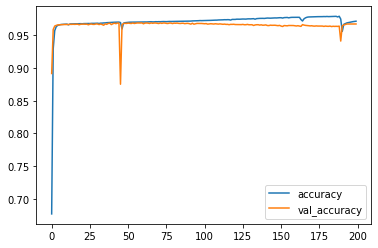

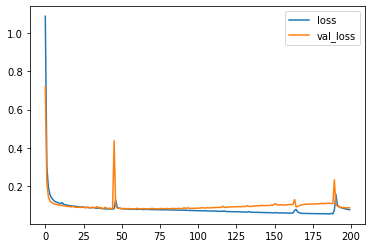

Training fold 1 completed. macro f1 score : 0.94115


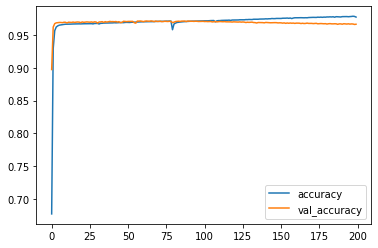

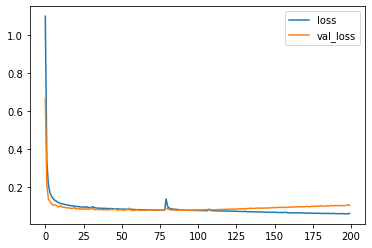

Training fold 2 completed. macro f1 score : 0.94248


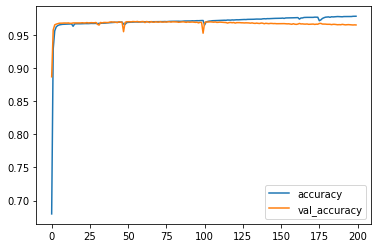

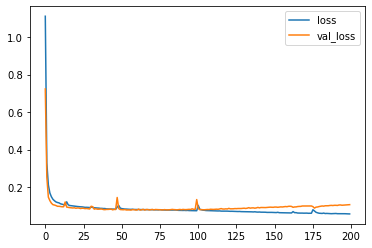

Training fold 3 completed. macro f1 score : 0.94065


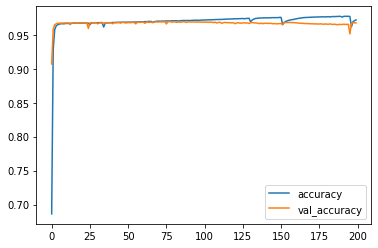

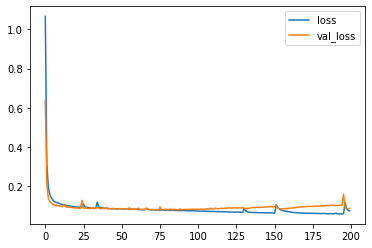

Training fold 4 completed. macro f1 score : 0.94047


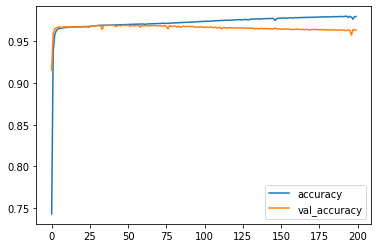

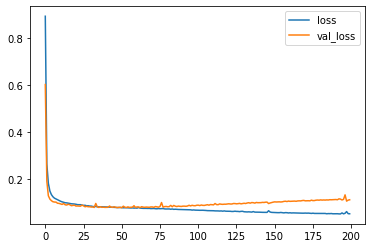

Training fold 5 completed. macro f1 score : 0.94133
Training completed. oof macro f1 score : 0.94125
Training completed


In [12]:
def run_everything():
    
    print('Reading Data Started...')
    train, test, sample_submission = read_data()
    train, test = normalize(train, test)
    print('Reading and Normalizing Data Completed...')
        
    print('Creating Features')
    print('Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size=GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size=GROUP_BATCH_SIZE)
    train, test, features = feature_selection(train, test)
    print('Feature Engineering Completed...')
        
   
    print(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started...')
    run_cv_model_by_batch(train, test, SPLITS, 'group', features, sample_submission, EPOCHS, NNBATCHSIZE)
    print('Training completed')
        
run_everything()